# Pendulum (Simple DeepQ Learning + Replay Memory) 

In [1]:
import gym
import numpy as np
import random
import imageio 
from matplotlib import pyplot as plt

The notebook is based on the work of [JM-Kim-94 on the Pendulum using DQN](https://github.com/JM-Kim-94/rl-pendulum/tree/master/Pendulum_DQN).

## Context

In [2]:
env = gym.make('Pendulum-v1', g=9.81)

The Pendulm is described on [gym](https://www.gymlibrary.dev/environments/classic_control/pendulum/) as : "The system consists of a pendulum attached at one end to a fixed point, and the other end being free. The pendulum starts in a random position and the goal is to apply torque on the free end to swing it into an upright position, with its center of gravity right above the fixed point."

Here we can not 2 actions but an infinity. Because we control the torque on the loose end, the torque can be any number as long as it is included between -2 and 2.
So as might begin to understand, we will have to discretize this interval with specific value that the torque can take, a bit more later...

In [13]:
env.action_space

Box(-2.0, 2.0, (1,), float32)

The observation state is a vector of 3 numbers : x, y and the angular velocity, all are bounded.

What's important is that the state is not discrete, so there is an infinite combination of state, making a QTable for such a problem is possible but not the right solution because of the infinite amount of state. 

In [4]:
env.observation_space.shape

(3,)

If a QTable is not the right solution, the only remaining is using DeepQ Learning.

Instead of creating a table that will store all the Qvalues, we use a neural network to approximatethose QValues. The neural network allow us to have an infinite number of states, it will only depends on the network's weights and not a static table.

## DeepQ Learning (With replay memory)

The difference between a simple DeepQ Learning alogorithm and another one using replay memory is that the first one will only learn from its last experience, unlike the other one that can learn from past experience. 

This simple make a huge difference, because without memory the model can't generalize well, and is very likely to not train on every possible situations.

### Replay Memory (deque)
First create the replay memory, that will store : the current state, the action taken, the reward, the next state, and if the state is terminal.

Basically, the memory doesn't have an infinite capcity (performance wise), so we setup the memory as a deque, it will automatically handle incoming experience, and throwing the older ones.


The methods created are :
- 'push' : it append a new experience to the memory
- 'sample' : it will randomly take some experience (a batch) in the memory and output them, those will be used to update the network weights.
- '__len__' : it overrides the 'len' methods to return the memory length, used to start updating network's weights when there are enough experience stored.

In [5]:
from collections import deque
class ReplayMemory:
    def __init__(self, capacity):
        self.memory = deque(maxlen=capacity)
    def push(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))
    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)
    def __len__(self):
        return len(self.memory)

### The network

The network can be set how you want, it doesn't need to be a very deep network, one hidden layer of 32 and 64 as input seems to be enough.


The input_shape or input, is what is received, the observation so a vector 3 values (Shape : (3,)).

The output are the QValues for the possible actions, in the case of the cart pole the action space had a size of 2 (left or right), here because the action space is continuous we have to discretize it to make the network predict actions, it can be : 2,6, 100...So we don't know yet how many unit the output layer will have, until you decide how may interval you want (how many actions), more details on the calculation below !

In [6]:
from keras import layers, Sequential, optimizers
def create_model(input_shape, output_shape, learning_rate):
    model = Sequential()
    model.add(layers.Dense(64, input_shape=(input_shape,), activation='relu'))
    model.add(layers.Dense(32, activation='relu'))
    model.add(layers.Dense(output_shape, activation='linear'))
    return model

### DeepQ Learning algorithm

The algorithm is pretty much the same as the QLearning one, the difference will be in the part of the QValue estimation.
Before, we would take the QTable, update the corresponding state with the action taken, here the updates are only made the networks learns from memory.

By taking a batch of past experiences we can compute the corresponding QValue, but instead of storing it in a table, we update the network's weights but training the model to associate the qvalues to a state in order to take the best action.

For the actions now !
As sais before, most of the time, in the tasks the number of actions are finite : goign up, down, take, drop...Here with the pendulum we control the troque applied, we only know that it has to be bounded between -2 and 2 and can take any values in this range. In order to make the neural network predict the torque, we have set a number of discrete interval that it can take. 
In this notebook we set this ouptut to be 9, so as you guess it means that the network will predict QValues for 9 possibles actions, given the torque bound the actions will be : -2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5 and 2. Now the goal is to bound the actions to the right interval :

[This link explains well the principle](https://stackoverflow.com/questions/5294955/how-to-scale-down-a-range-of-numbers-with-a-known-min-and-max-value), we scale the number given a max and min. The neural network will predict 9 QValues, we take the argmax to know which one to take, the result of argmax is an 'int' between 0 and 8 (because 9 values on output), and by applying the formula we have :

$$ \frac{(2 - (-2))*(x-0)}{8-0} - 2 = \frac{4x}{8}-2 = \frac{x}{2}-2 = \frac{x-4}{2}$$

To conclude, in the memory we use the action resulting from the argmax, but to update the environnement (step) we use the action resulting the argamx scaled between -2 and 2.

Hope it's clear !


This calculation apart, the rest of the algorithm is EXACTLY the same as in the Cart Pole.

In [7]:
rewards_list = []

def DeepQLearning(env, learning_rate, discount, epsilon, max_steps, episodes, batch_size_p=32):
    
    input_shape = env.observation_space.shape[0]
    output_shape = 9

    model = create_model(
        input_shape=input_shape, 
        output_shape=output_shape, 
        learning_rate=learning_rate)

    model.compile(loss='mse', optimizer=optimizers.Adam(learning_rate = learning_rate))


    memory = ReplayMemory(capacity=100000)
    batch_size = batch_size_p
    

    for i in range(episodes):
        state, info = env.reset()
        state = state.reshape(1, input_shape)
        done = False
        reward_tot = 0

        if i > 50:
            #model.save_weights(f"model.weights-eps{i}.h5")
            model.save_weights("model.weights.h5", overwrite=True)

        
        for j in range (max_steps): 

            if np.random.rand() <= epsilon:
                action = np.random.choice([n for n in range(9)])
                real_action = (action - 4) / 2
            else:
                action = np.argmax(model.predict(state, verbose=0)[0])
                real_action = (action - 4) / 2

            new_state, reward, done, truncated, info = env.step([real_action])
            new_state = new_state.reshape(1, input_shape) 
            reward_tot += reward

            memory.push(state, action, reward, new_state, done)
            state = new_state

            
            # Only update the model if there are enough experiences in memory
            if len(memory) >= batch_size:
                
                states, actions, rewards, new_states, dones = zip(*memory.sample(batch_size))

                
                dones = np.array(dones, dtype=np.bool_)
                #states = np.array(states)
                states = np.squeeze(states)
                ####
                actions = np.array(actions)
                ####
                
                #new_states = np.array(new_states)
                new_states = np.squeeze(new_states)
                
                targets = model.predict_on_batch(states)

                #q_values_next = target_model.predict_on_batch(new_states)
                q_values_next = model.predict_on_batch(new_states)


                max_q_values_next = np.amax(q_values_next, axis=1)
                
                targets[range(batch_size), actions] = rewards + discount * max_q_values_next *  (1 - dones) 

                model.fit(states, targets, epochs=1, verbose=0)

                model.save_weights('model.weights.h5', overwrite=True)
                


            if done:
                break

        print("Episodes n°:", i, "Epsilon:", epsilon, "Total reward:", reward_tot)
        rewards_list.append(reward_tot)
        if epsilon > 0.001:
            epsilon *= 0.98




## Training time !

In [8]:
DeepQLearning(env, 
          learning_rate=0.01, 
          discount=0.99, 
          epsilon=1.0, 
          max_steps=200, 
          episodes=400,
          batch_size_p=256)

c:\Python311\Lib\site-packages\gym\utils\passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


Episodes n°: 0 Epsilon: 1.0 Total reward: -1213.5470008906775
Episodes n°: 1 Epsilon: 0.98 Total reward: -1170.00737476973
Episodes n°: 2 Epsilon: 0.9603999999999999 Total reward: -1050.4880862942064
Episodes n°: 3 Epsilon: 0.9411919999999999 Total reward: -930.4763321555163
Episodes n°: 4 Epsilon: 0.9223681599999999 Total reward: -1079.962183165902
Episodes n°: 5 Epsilon: 0.9039207967999998 Total reward: -907.2312289654893
Episodes n°: 6 Epsilon: 0.8858423808639998 Total reward: -1269.6063958447553
Episodes n°: 7 Epsilon: 0.8681255332467198 Total reward: -1074.4681448795823
Episodes n°: 8 Epsilon: 0.8507630225817854 Total reward: -861.0338621391028
Episodes n°: 9 Epsilon: 0.8337477621301497 Total reward: -842.8240132916073
Episodes n°: 10 Epsilon: 0.8170728068875467 Total reward: -756.8536777737677
Episodes n°: 11 Epsilon: 0.8007313507497957 Total reward: -615.9463374760873
Episodes n°: 12 Epsilon: 0.7847167237347998 Total reward: -1413.9125719510623
Episodes n°: 13 Epsilon: 0.7690223

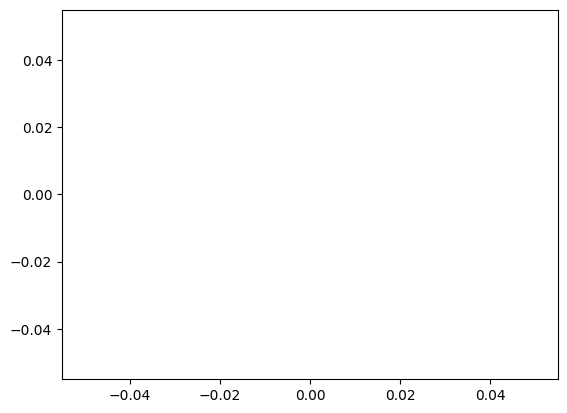

In [8]:
plt.plot(rewards_list)

## Create the GIF

In [12]:
images = []
env = gym.make('Pendulum-v1', g=9.81, render_mode='rgb_array')
state,info = env.reset()


input_shape = env.observation_space.shape[0]
output_shape = 9

state = state.reshape(1, input_shape)


model = create_model(
        input_shape=input_shape, 
        output_shape=output_shape, 
        learning_rate=0.001
)
model.load_weights('model.weights.h5')
model.compile(loss='mse', optimizer=optimizers.Adam(learning_rate = 0.001))

score = 0
done = False

stp = 0
while stp < 600:

        stp += 1
        print(stp)

        action = np.argmax(model.predict(state, verbose=0))
        real_action = (action - 4) / 2

        new_state, reward, done, trunc, info = env.step([real_action])
        state = new_state.reshape(1, input_shape) 

        frame = env.render()  # Save the frame
        images.append(frame)


        if done == True:
                break
        score +=1

env.close()
imageio.mimsave('img/PendulumDQN4.gif', images, fps=30)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277
